# Ada Boost

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt

/home/serafima/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Считает ошибку
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f' % err)

def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)
    
# График для ошибки после обучения алгоритма
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

Ada boost implementation:

In [3]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights (1 поделить на размер выборки)
    w = np.array([1. / n_train for elem in range(n_train)]) # my code
    #w = np.ones(n_train)
    #print(type(w))
    #print(w)
    
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):  # M - количество деревьев
        #print(i)
        # Fit a classifier with the specific weights
        #<YOUR CODE HERE> sample weights
        clf.fit(X_train, Y_train, sample_weight=w)
        pred_train_i = clf.predict(X_train)  # my code
        pred_test_i = clf.predict(X_test)  # my code
        
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha (гамма в тетради)
        alpha_m = np.log((1. - err_m) / err_m) / 2.  # my code
        # New weights (+отнормировать веса)
        # ....
        
        w = (w * np.exp(alpha_m * Y_train * pred_train+i)) / sum(w)  #my code
        w = np.array(w)
        #print(type(w))
        
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)



Чтение входных данных:

In [4]:
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y

Делим данные на train и test:

In [5]:
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.ix[:,:-1], train.ix[:,-1]
X_test, Y_test = test.ix[:,:-1], test.ix[:,-1]

Обучаем решающее дерево:

In [6]:
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)

In [9]:
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 500, 10)
for i in x_range:    
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])

/home/serafima/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/serafima/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:280: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(sample_weight))


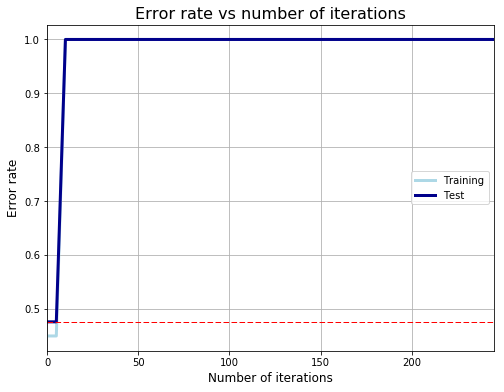

In [10]:
plot_error_rate(er_train, er_test)
plt.show()
